In [1]:
import os
os.chdir("..")

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from umap import umap_
import cv2
import matplotlib.pyplot as plt
import tqdm

c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\angelo\AppData\Local\Programs\Python\Pyth

In [3]:
import platform

if platform.system() == "Windows":
    DEL = "\\"
else:
    DEL = "/"

In [4]:
class ImagePairDataset(Dataset):
    def __init__(self, datadir, transform=None):
        """
        Returns images as numpy arrays opened via opencv if not specified otherwise in `transform`.
        """
        self.datadir = os.getcwd() + DEL + datadir
        filenames = os.listdir(f"{self.datadir}{DEL}first")
        self.length = len(filenames)
        if "_" in filenames[0]:
            self.label_prefix0 = "_0"
            self.label_prefix1 = "_1"
        else:
            self.label_prefix0 = ""
            self.label_prefix1 = ""
        self.transform = transform

    def __getitem__(self, index):
        label = None
        image1 = cv2.imread(f"{self.datadir}{DEL}first{DEL}{index}{self.label_prefix1}.jpg")
        if image1 is not None:
            label = 1
            image2 = cv2.imread(f"{self.datadir}{DEL}second{DEL}{index}{self.label_prefix1}.jpg")
            if image2 is None:
                return self.__getitem__((index+1) % self.__len__())
        else:
            image1 = cv2.imread(f"{self.datadir}{DEL}first{DEL}{index}{self.label_prefix0}.jpg")
            if image1 is None:
                return self.__getitem__((index+1) % self.__len__())
            label = 0
            image2 = cv2.imread(f"{self.datadir}{DEL}second{DEL}{index}{self.label_prefix0}.jpg")
            if image2 is None:
                return self.__getitem__((index+1) % self.__len__())

        image1 = cv2.resize(image1, (256, 256))
        image2 = cv2.resize(image2, (256, 256))
        image1 = torch.from_numpy(image1).float()
        image2 = torch.from_numpy(image2).float()
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image1)

        return image1, image2, label

    def __len__(self):
        return self.length

In [5]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor()
])
image_pair_train_data = ImagePairDataset("data\\train")

In [6]:
def train_dists(dataset, n_samples=10000, plot_same=False):
    dataloader = DataLoader(dataset=dataset, batch_size=n_samples, shuffle=True, drop_last=True)
    iterator = iter(dataloader)
    images1, images2, labels = next(iterator)

    dists = torch.norm(torch.reshape(images1, (n_samples, -1)) - torch.reshape(images2, (n_samples, -1)), dim=[1])
    zeros = dists[labels == 0]
    ones = dists[labels == 1]
    

    for i, label in enumerate(labels):
        if label == 1 and dists[i] > 20000 and plot_same:
            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(images1[i], cmap='gray')
            axes[0].axis('off')
            axes[1].imshow(images2[i], cmap='gray')
            axes[1].axis('off')

    return zeros, ones

In [10]:
zeros, ones = train_dists(image_pair_train_data, 10, plot_same=True)

In [8]:
def plot_train_dist_distr(zeros, ones):
    bin_edges = [0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500,
    30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000, 52500, 55000, 57500, 60000, 62500, 65000, 67500, 70000, 72500, 75000]
    plt.hist(zeros, bins=bin_edges, color='blue', alpha=0.7, label='Different images')
    plt.hist(ones, bins=bin_edges, color='green', alpha=0.7, label='Same images')

    plt.xlabel('Distance')
    plt.ylabel('Count')
    plt.title('Countplots of Distances')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

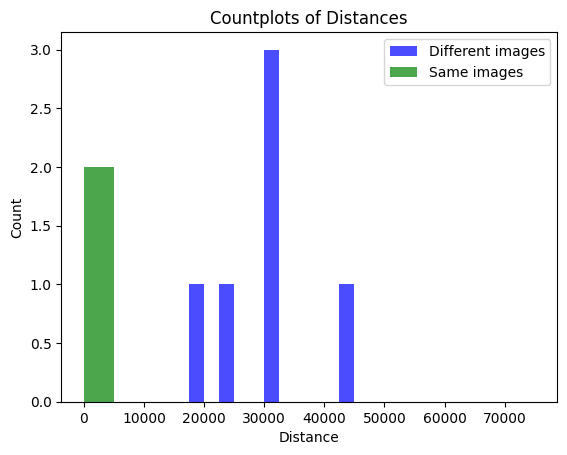

In [11]:
plot_train_dist_distr(zeros, ones)

In [12]:
zeros, ones = train_dists(image_pair_train_data, n_samples=1000)

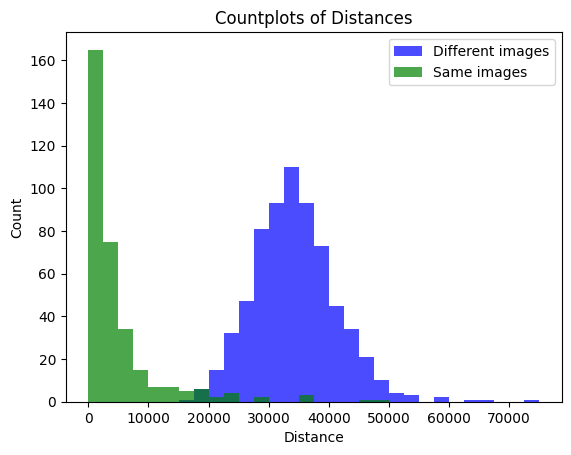

In [13]:
plot_train_dist_distr(zeros, ones)

In [14]:
image_pair_test_data = ImagePairDataset("data\\test")

In [15]:
def test_dists(dataset, n_samples=1000, plot_same=False):
    dataloader = DataLoader(dataset=dataset, batch_size=n_samples, shuffle=True, drop_last=True)
    iterator = iter(dataloader)
    images1, images2, _ = next(iterator)

    dists = torch.norm(torch.reshape(images1, (n_samples, -1)) - torch.reshape(images2, (n_samples, -1)), dim=[1])

    return dists

In [16]:
def plot_test_dist_distr(dist):
    bin_edges = [0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500,
    30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000, 52500, 55000, 57500, 60000, 62500, 65000, 67500, 70000, 72500, 75000]
    plt.hist(dist, bins=bin_edges, color='blue', alpha=0.7, label='Distances')

    plt.xlabel('Distance')
    plt.ylabel('Count')
    plt.title('Countplots of Distances')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

In [18]:
dists = test_dists(image_pair_test_data, 3000, plot_same=False)

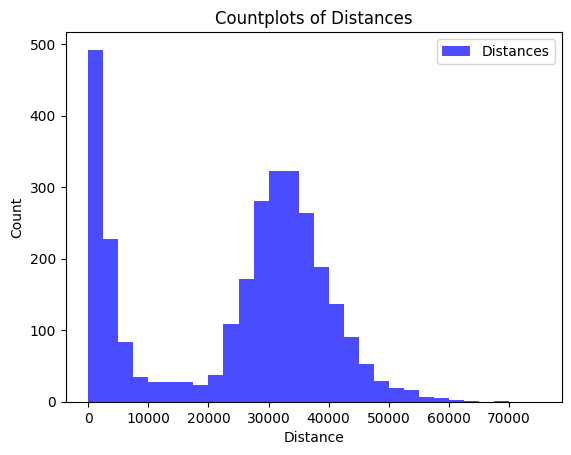

In [19]:
plot_test_dist_distr(dists)